<a href="https://colab.research.google.com/github/INmais/Energy_Services_2022/blob/main/Energy_Services_2022_Class_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If needed install libraries

In [2]:
#needs to be installed first (geopadas), otherwise rtree for spatial operatios will not work
!pip install fiona shapely pyproj rtree 

In [4]:
! pip install geopandas
! pip install requests
! pip install glob2 #for merging csv's
! pip install seaborn
! pip install folium 

### Step 1: Import  libraries

In [5]:
#import required libraries

#base
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for merging cvs's
import glob2

# for usinng paths
from pathlib import Path

#dealing with GIS and shapes
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import fiona

In [6]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/',force_remount=True) #

Mounted at /content/drive/


### Step 2: Import data 

Reading from Github
You need to get path to the "raw file", so using Energy_Services_2022 Repo: https://github.com/INmais/Energy_Services_2022

Eg. select "energia.csv" file ("https://github.com/INmais/Energy_Services_2022/blob/main/Data/energia.csv"), then click on "Raw"

Copy the path "https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/temperature.csv" and:

In [7]:
DATA_FILEPATH_temp = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/temperature.csv' 
raw_data_temp = pd.read_csv(DATA_FILEPATH_temp)
raw_data_temp['Date'] = pd.to_datetime(raw_data_temp['Date'], format='%d/%m/%Y %H:%M')
raw_data_temp.tail(10)

,Date,celsius
658,2019-03-11 04:00:00,18.733333
659,2019-03-11 05:00:00,18.663333
660,2019-03-11 06:00:00,18.585833
661,2019-03-11 07:00:00,18.584167
662,2019-03-11 08:00:00,19.222500
663,2019-03-11 09:00:00,22.584167
664,2019-03-11 10:00:00,23.836667
665,2019-03-11 11:00:00,24.785000
666,2019-03-11 12:00:00,23.811667
667,2019-03-11 13:00:00,22.831429


In [8]:
raw_data_temp = raw_data_temp.set_index('Date')

In [9]:
#resample
raw_data_temp.resample('3H').median()

,celsius
Date,
2019-02-11 18:00:00,17.375000
2019-02-11 21:00:00,16.935000
2019-02-12 00:00:00,16.650833
2019-02-12 03:00:00,16.329167
2019-02-12 06:00:00,16.081667
...,...
2019-03-11 00:00:00,18.936667
2019-03-11 03:00:00,18.733333
2019-03-11 06:00:00,18.585833


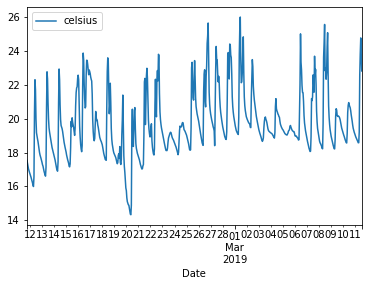

In [10]:
raw_data_temp.plot()

In [11]:
DATA_FILEPATH_CO2 = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/co2.csv' 
raw_data_co2 = pd.read_csv(DATA_FILEPATH_CO2)
raw_data_co2['Date'] = pd.to_datetime(raw_data_co2['Date'], format='%d/%m/%Y %H:%M')
raw_data_co2.fillna(value=0).head(5)

,Date,ppm
0,2019-02-11 18:00:00,457.000000
1,2019-02-11 19:00:00,450.583333
2,2019-02-11 20:00:00,447.416667
3,2019-02-11 21:00:00,443.583333
4,2019-02-11 22:00:00,439.000000


In [12]:
DATA_FILEPATH_wifi = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/wifi.csv' 
raw_data_wifi = pd.read_csv(DATA_FILEPATH_wifi)
raw_data_wifi['Date'] = pd.to_datetime(raw_data_wifi['Date'], format='%d/%m/%Y %H:%M')
raw_data_wifi.fillna(value=0).head(5)

,Date,eduroam,tecnico-guest
0,2019-02-11 14:30:00,0.000,0.0
1,2019-02-11 14:45:00,0.331,0.0
2,2019-02-11 15:00:00,1.320,0.0
3,2019-02-11 15:15:00,1.000,0.0
4,2019-02-11 15:30:00,0.682,0.0


### Step 3: Manage data

In [13]:
all_data=pd.merge(raw_data_co2,raw_data_temp,on='Date')

In [14]:
print(all_data)

                   Date          ppm    celsius
0   2019-02-11 18:00:00   457.000000  17.548000
1   2019-02-11 19:00:00   450.583333  17.375000
2   2019-02-11 20:00:00   447.416667  17.193333
3   2019-02-11 21:00:00   443.583333  17.045833
4   2019-02-11 22:00:00   439.000000  16.935000
..                  ...          ...        ...
663 2019-03-11 09:00:00  1939.000000  22.584167
664 2019-03-11 10:00:00  1078.166667  23.836667
665 2019-03-11 11:00:00  1229.166667  24.785000
666 2019-03-11 12:00:00   498.750000  23.811667
667 2019-03-11 13:00:00   482.571429  22.831429

[668 rows x 3 columns]


In [15]:
all_data=pd.merge(all_data,raw_data_wifi,on='Date')

In [16]:
print(all_data)

                   Date          ppm    celsius  eduroam   tecnico-guest 
0   2019-02-11 18:00:00   457.000000  17.548000     10.70           0.000
1   2019-02-11 19:00:00   450.583333  17.375000      1.00           0.000
2   2019-02-11 20:00:00   447.416667  17.193333      0.00           0.317
3   2019-02-11 21:00:00   443.583333  17.045833      0.00           0.000
4   2019-02-11 22:00:00   439.000000  16.935000      0.00           0.000
..                  ...          ...        ...       ...             ...
663 2019-03-11 09:00:00  1939.000000  22.584167      8.01           1.000
664 2019-03-11 10:00:00  1078.166667  23.836667     19.00           1.320
665 2019-03-11 11:00:00  1229.166667  24.785000     40.30           2.000
666 2019-03-11 12:00:00   498.750000  23.811667     52.70           1.340
667 2019-03-11 13:00:00   482.571429  22.831429     87.40           1.670

[668 rows x 5 columns]


In [17]:
#see the first 5 rows of data
all_data.head()

,Date,ppm,celsius,eduroam,tecnico-guest
0,2019-02-11 18:00:00,457.000000,17.548000,10.7,0.000
1,2019-02-11 19:00:00,450.583333,17.375000,1.0,0.000
2,2019-02-11 20:00:00,447.416667,17.193333,0.0,0.317
3,2019-02-11 21:00:00,443.583333,17.045833,0.0,0.000
4,2019-02-11 22:00:00,439.000000,16.935000,0.0,0.000


In [18]:
#see the last 10 rows of data
all_data.tail(10)

,Date,ppm,celsius,eduroam,tecnico-guest
658,2019-03-11 04:00:00,412.333333,18.733333,0.00,1.00
659,2019-03-11 05:00:00,414.416667,18.663333,0.00,1.00
660,2019-03-11 06:00:00,414.416667,18.585833,0.00,1.00
661,2019-03-11 07:00:00,418.166667,18.584167,0.00,1.00
662,2019-03-11 08:00:00,478.916667,19.222500,0.00,1.00
663,2019-03-11 09:00:00,1939.000000,22.584167,8.01,1.00
664,2019-03-11 10:00:00,1078.166667,23.836667,19.00,1.32
665,2019-03-11 11:00:00,1229.166667,24.785000,40.30,2.00
666,2019-03-11 12:00:00,498.750000,23.811667,52.70,1.34
667,2019-03-11 13:00:00,482.571429,22.831429,87.40,1.67


In [19]:
#see types of data
all_data.dtypes

Date              datetime64[ns]
ppm                      float64
celsius                  float64
eduroam                  float64
tecnico-guest            float64
dtype: object

In [20]:
#see size of data
all_data.shape #668 rows, 5 columns 

(668, 5)

In [21]:
#first row is the columns headers
#first column is the index of rows, starting in 0

#see columns headers
all_data.columns

Index(['Date', 'ppm', 'celsius', 'eduroam ', 'tecnico-guest '], dtype='object')

In [22]:
# change name to column header 'eduroam ' as it has a blank space
all_data=all_data.rename(columns={'tecnico-guest ':'tecnico-guest'})
all_data=all_data.rename(columns={'eduroam ':'eduroam'})

In [23]:
all_data.columns

Index(['Date', 'ppm', 'celsius', 'eduroam', 'tecnico-guest'], dtype='object')

In [24]:
all_data=all_data.drop(columns='tecnico-guest')

In [25]:
all_data = all_data.set_index('Date')

### Step 4: Display Data

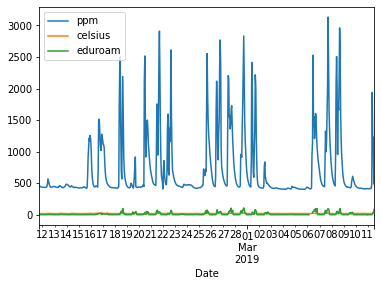

In [26]:
all_data.plot()

In [27]:
fig=plt.figure()
fig.set_size_inches(18.5, 10.5)

<Figure size 1332x756 with 0 Axes>

In [28]:
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)

In [29]:
ax1.plot(all_data['celsius'], 'g-')
ax1.set_ylabel('ºC')
ax2.plot(all_data['ppm'], 'r-')
ax2.set_ylabel('PPM')
ax3.plot(all_data['eduroam'], 'm-')
ax3.set_ylabel('#users')

Text(0, 0.5, '#users')

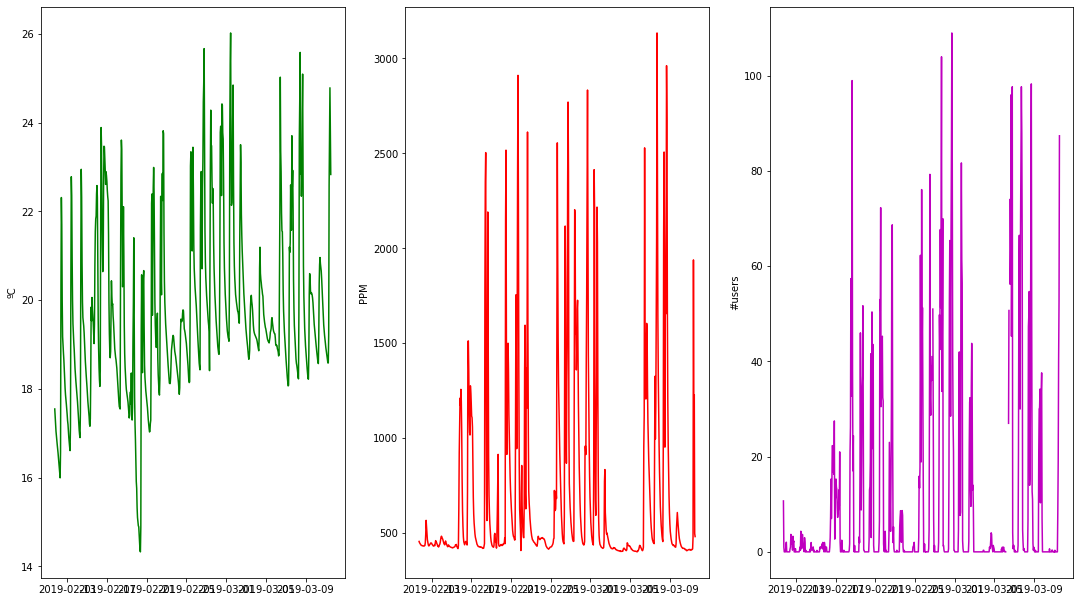

In [30]:
fig

In [31]:
# Using plotly.express
import plotly.express as px
fig = px.line(all_data, x=all_data.index, y="celsius")
fig.show()

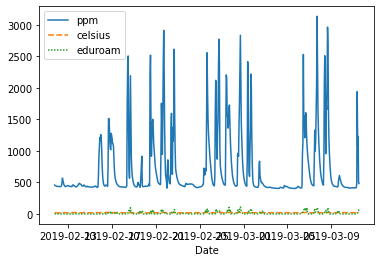

In [32]:
#seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data = all_data)

### Step 5: Calculate basic statistics

(array([ 3.,  1.,  4.,  1.,  1.,  0.,  2.,  2.,  4.,  4.,  5., 10., 15.,
        20., 13., 21., 29., 31., 35., 52., 59., 50., 41., 29., 35., 16.,
        16., 22., 12., 11.,  9.,  3.,  7., 11., 15., 17., 14.,  5.,  5.,
        12.,  9.,  2.,  2.,  4.,  2.,  2.,  2.,  0.,  2.,  1.]),
 array([14.32833333, 14.56216666, 14.796     , 15.02983333, 15.26366666,
        15.4975    , 15.73133333, 15.96516666, 16.199     , 16.43283333,
        16.66666666, 16.9005    , 17.13433333, 17.36816666, 17.602     ,
        17.83583333, 18.06966666, 18.3035    , 18.53733333, 18.77116666,
        19.005     , 19.23883333, 19.47266666, 19.7065    , 19.94033333,
        20.17416667, 20.408     , 20.64183333, 20.87566667, 21.1095    ,
        21.34333333, 21.57716667, 21.811     , 22.04483333, 22.27866667,
        22.5125    , 22.74633333, 22.98016667, 23.214     , 23.44783333,
        23.68166667, 23.9155    , 24.14933333, 24.38316667, 24.617     ,
        24.85083333, 25.08466667, 25.3185    , 25.55233333,

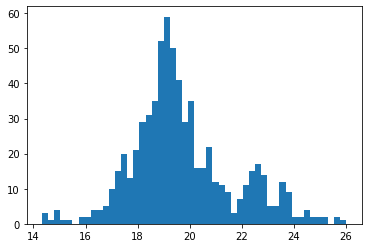

In [33]:
fig2=plt.figure()
plt.hist(all_data['celsius'],50)

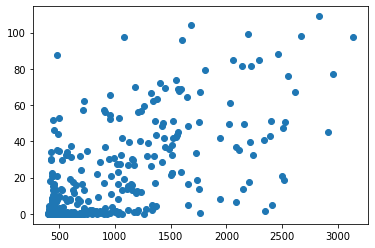

In [34]:
fig3=plt.figure()
plt.scatter(all_data['ppm'],all_data['eduroam'])

# Basic Statistics

# Curret date

In [35]:
DATA_FILEPATH_temp2 = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/temperatura.csv' 
raw_data_temp2 = pd.read_csv(DATA_FILEPATH_temp2, parse_dates=[0], index_col=[0], infer_datetime_format=True)
raw_data_temp2.fillna(value=0).head(5)

,Tempo,Qualidade do Ar sala V1.10
2022-02-06 18:00:00,20,33
2022-02-06 19:00:00,20,24727272727273
2022-02-06 20:00:00,20,69166666666668
2022-02-06 21:00:00,19,915833333333335
2022-02-06 22:00:00,19,78666666666667


In [36]:
raw_data_temp2['Tempo'] = raw_data_temp2['Tempo'].astype(str)
raw_data_temp2['Qualidade do Ar sala V1.10'] = raw_data_temp2['Qualidade do Ar sala V1.10'].astype(str)
raw_data_temp2['temp'] = raw_data_temp2['Tempo'] + '.'+ raw_data_temp2['Qualidade do Ar sala V1.10']

In [37]:
raw_data_temp2['temp'] = raw_data_temp2['temp'].astype(float)

In [38]:
raw_data_temp2 = raw_data_temp2[['temp']]

In [39]:
raw_data_temp2 

,temp
2022-02-06 18:00:00,20.330000
2022-02-06 19:00:00,20.247273
2022-02-06 20:00:00,20.691667
2022-02-06 21:00:00,19.915833
2022-02-06 22:00:00,19.786667
...,...
2022-03-09 07:00:00,20.473333
2022-03-09 08:00:00,21.311667
2022-03-09 09:00:00,22.351667
2022-03-09 10:00:00,22.165000


In [10]:
import pandas as pd
DATA_FILEPATH_co2_2 = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/dioxido-de-carbono2.csv' 
raw_data_co2_2 = pd.read_csv(DATA_FILEPATH_co2_2, parse_dates=[0], index_col=[0], infer_datetime_format=True, sep=';')
raw_data_co2_2 = raw_data_co2_2.fillna(value=0)
raw_data_co2_2['Unnamed: 2'] = raw_data_co2_2['Unnamed: 2'].astype(int) #otherwise the workaround will not work

In [7]:
raw_data_co2_2 

,Qualidade do Ar sala V1.10,Unnamed: 2
Tempo,,
2022-02-06 18:00:00,417,0
2022-02-06 19:00:00,421,6363636363636
2022-02-06 20:00:00,423,1666666666667
2022-02-06 21:00:00,419,8333333333333
2022-02-06 22:00:00,418,9166666666667
...,...,...
2022-03-09 07:00:00,432,1666666666667
2022-03-09 08:00:00,435,75
2022-03-09 09:00:00,454,833333333333


In [5]:
raw_data_co2_2['Qualidade do Ar sala V1.10'] = raw_data_co2_2['Qualidade do Ar sala V1.10'].astype(str)
raw_data_co2_2['Unnamed: 2'] = raw_data_co2_2['Unnamed: 2'].astype(str)
raw_data_co2_2['co2'] = raw_data_co2_2['Qualidade do Ar sala V1.10'] + '.' + raw_data_co2_2['Unnamed: 2']
raw_data_co2_2.head(10)

,Qualidade do Ar sala V1.10,Unnamed: 2,co2
Tempo,,,
2022-02-06 18:00:00,417,0,417.0
2022-02-06 19:00:00,421,6363636363636,421.6363636363636
2022-02-06 20:00:00,423,1666666666667,423.1666666666667
2022-02-06 21:00:00,419,8333333333333,419.8333333333333
2022-02-06 22:00:00,418,9166666666667,418.9166666666667
2022-02-06 23:00:00,418,75,418.75
2022-02-07 00:00:00,419,833333333333,419.833333333333
2022-02-07 01:00:00,418,6666666666667,418.6666666666667
2022-02-07 02:00:00,419,25,419.25


In [42]:
raw_data_co2_2['co2'] = raw_data_co2_2['co2'].astype(float)

In [43]:
raw_data_co2_2 = raw_data_co2_2[['co2']]

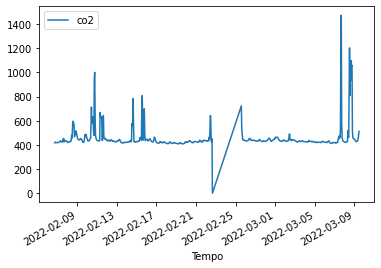

In [44]:
raw_data_co2_2.plot()

In [45]:
raw_data_co2_2.describe()

,co2
count,669.000000
mean,454.277114
std,99.135401
min,0.000000
25%,423.750000
50%,431.750000
75%,442.166667
max,1473.583333


In [46]:
DATA_FILEPATH_energy = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/energia.csv' 
raw_data_energy = pd.read_csv(DATA_FILEPATH_energy, sep=',',parse_dates=[0], index_col=[0], infer_datetime_format=True)
raw_data_energy.fillna(value=0).head(5)

,Tempo,V1.10 Energia
2022-02-15 14:00:00,396,33162921348315
2022-02-15 15:00:00,394,6953299492385
2022-02-15 16:00:00,383,30595744680835
2022-02-15 17:00:00,269,92062500000003
2022-02-15 18:00:00,389,2642424242424


In [47]:
raw_data_energy['Tempo'] = raw_data_energy['Tempo'].astype(str)
raw_data_energy['V1.10 Energia'] = raw_data_energy['V1.10 Energia'].astype(str)
raw_data_energy['energy'] = raw_data_energy['Tempo'] + '.'+ raw_data_energy['V1.10 Energia']

In [48]:
raw_data_energy['energy'] = raw_data_energy['energy'].astype(float)

In [49]:
raw_data_energy = raw_data_energy[['energy']]

In [50]:
DATA_FILEPATH_humidade = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/humidade.csv' 
raw_data_humidade = pd.read_csv(DATA_FILEPATH_humidade, parse_dates=[0], index_col=[0], infer_datetime_format=True)
raw_data_humidade.fillna(value=0).head(5)

,Tempo,Qualidade do Ar sala V1.10
2022-02-06 18:00:00,37,36
2022-02-06 19:00:00,37,96000000000001
2022-02-06 20:00:00,38,29583333333333
2022-02-06 21:00:00,38,81166666666666
2022-02-06 22:00:00,37,79250000000001


In [51]:
raw_data_humidade['Tempo'] = raw_data_humidade['Tempo'].astype(str)
raw_data_humidade['Qualidade do Ar sala V1.10'] = raw_data_humidade['Qualidade do Ar sala V1.10'].astype(str)
raw_data_humidade['new'] = raw_data_humidade['Tempo'] + '.'+ raw_data_humidade['Qualidade do Ar sala V1.10']

In [52]:
raw_data_humidade['humidade'] = raw_data_humidade['new'].astype(float)

In [53]:
raw_data_humidade = raw_data_humidade[['humidade']]

## Concat

See "Merge, join, concatenate and compare"

url:
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [54]:
result = pd.concat([raw_data_temp2, raw_data_co2_2], axis=1)

In [55]:
result1 = pd.concat([result, raw_data_energy], axis=1)

In [56]:
result2 = pd.concat([result1, raw_data_humidade], axis=1)

In [57]:
result2

,temp,co2,energy,humidade
2022-02-06 18:00:00,20.330000,417.000000,NaN,37.360000
2022-02-06 19:00:00,20.247273,421.636364,NaN,37.960000
2022-02-06 20:00:00,20.691667,423.166667,NaN,38.295833
2022-02-06 21:00:00,19.915833,419.833333,NaN,38.811667
2022-02-06 22:00:00,19.786667,418.916667,NaN,37.792500
...,...,...,...,...
2022-03-09 07:00:00,20.473333,432.166667,5.540000,54.675000
2022-03-09 08:00:00,21.311667,435.750000,5.531667,52.250000
2022-03-09 09:00:00,22.351667,454.833333,5.528000,48.405833
2022-03-09 10:00:00,22.165000,487.166667,90.852542,48.425833


## Missing values

easy fix: remove rows

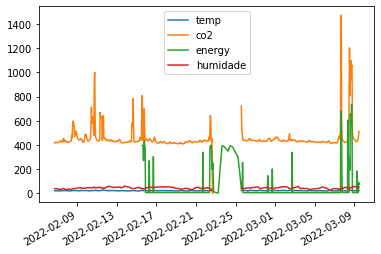

In [58]:
result2.plot()

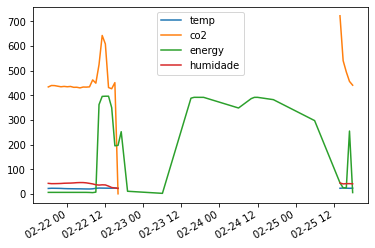

In [59]:
result2["2022-02-21 18:00:00":"2022-02-25 18:00:00"].plot();

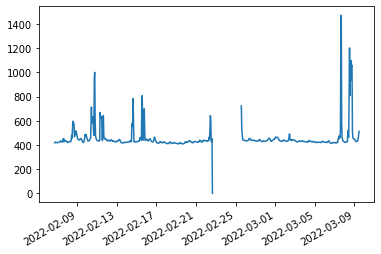

In [60]:
result2['co2'].plot()

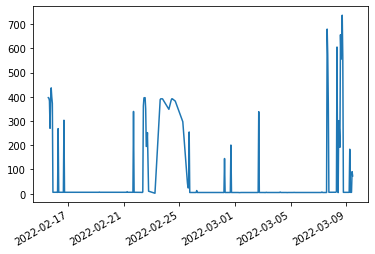

In [61]:
result2['energy'].plot()

In [62]:
result2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 683 entries, 2022-02-06 18:00:00 to 2022-03-09 11:00:00
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      669 non-null    float64
 1   co2       669 non-null    float64
 2   energy    471 non-null    float64
 3   humidade  669 non-null    float64
dtypes: float64(4)
memory usage: 42.8 KB


fillna() can “fill in” NA values with non-NA data

pad / ffill : Fill values forward

bfill / backfill : Fill values backward

times series imputa

pd.Series([np.nan]).sum()

In [63]:
result2.resample('1H').mean().ffill()

,temp,co2,energy,humidade
2022-02-06 18:00:00,20.330000,417.000000,NaN,37.360000
2022-02-06 19:00:00,20.247273,421.636364,NaN,37.960000
2022-02-06 20:00:00,20.691667,423.166667,NaN,38.295833
2022-02-06 21:00:00,19.915833,419.833333,NaN,38.811667
2022-02-06 22:00:00,19.786667,418.916667,NaN,37.792500
...,...,...,...,...
2022-03-09 07:00:00,20.473333,432.166667,5.540000,54.675000
2022-03-09 08:00:00,21.311667,435.750000,5.531667,52.250000
2022-03-09 09:00:00,22.351667,454.833333,5.528000,48.405833
2022-03-09 10:00:00,22.165000,487.166667,90.852542,48.425833


In [64]:
result2['energy'].resample('1H').mean().bfill()

2022-02-06 18:00:00    396.331629
2022-02-06 19:00:00    396.331629
2022-02-06 20:00:00    396.331629
2022-02-06 21:00:00    396.331629
2022-02-06 22:00:00    396.331629
                          ...    
2022-03-09 07:00:00      5.540000
2022-03-09 08:00:00      5.531667
2022-03-09 09:00:00      5.528000
2022-03-09 10:00:00     90.852542
2022-03-09 11:00:00     73.205217
Freq: H, Name: energy, Length: 738, dtype: float64

In [65]:
result2['energy'].resample('1H').mean().interpolate()

2022-02-06 18:00:00          NaN
2022-02-06 19:00:00          NaN
2022-02-06 20:00:00          NaN
2022-02-06 21:00:00          NaN
2022-02-06 22:00:00          NaN
                         ...    
2022-03-09 07:00:00     5.540000
2022-03-09 08:00:00     5.531667
2022-03-09 09:00:00     5.528000
2022-03-09 10:00:00    90.852542
2022-03-09 11:00:00    73.205217
Freq: H, Name: energy, Length: 738, dtype: float64

#Facebook

### Facebook mobility range

#### Facebook Movement Range data contains two types of data:

* Stationary share

  * Percentage of Facebook users (mobile app + location history) that were present in only one such level 16 Bing tile in at least 3 different hours of the day.
all_day_ratio_single_tile_users. The percentage of users always on the same map tile, relative to a baseline last months.
    * "Stay-Put: change in the proportion of users staying put within a single Bing level-16 tile.",

* Mobility range

  * This data shows the average number of level 16 Bing tiles (0.6km by 0.6km) that a Facebook user (mobile app + location history) was present in during a 24 hour period compared to pre-crisis levels. This is called the Travel Range map.
all_day_bing_tiles_visited_relative_chang.
How many map tiles were touched by users, relative to a baseline in the last months.
  * "Movement: change in movement, measured by the average number of distinct Bing level-16 tiles users visit."


* "Bing level-16 tile: approximately a 600 meters by 600 meters area.",
"""

In [ ]:

!ls "/content/drive/MyDrive/EPP/Science Dissemination and Teaching Skills - Dem/Data/316799354532909_2022-02-07_2022-03-08_csv"

316799354532909_2022-02-07_0000.csv  316799354532909_2022-02-21_1600.csv
316799354532909_2022-02-07_0800.csv  316799354532909_2022-02-22_0000.csv
316799354532909_2022-02-07_1600.csv  316799354532909_2022-02-22_0800.csv
316799354532909_2022-02-08_0000.csv  316799354532909_2022-02-22_1600.csv
316799354532909_2022-02-08_0800.csv  316799354532909_2022-02-23_0000.csv
316799354532909_2022-02-08_1600.csv  316799354532909_2022-02-23_0800.csv
316799354532909_2022-02-09_0000.csv  316799354532909_2022-02-23_1600.csv
316799354532909_2022-02-09_0800.csv  316799354532909_2022-02-24_0000.csv
316799354532909_2022-02-09_1600.csv  316799354532909_2022-02-24_0800.csv
316799354532909_2022-02-10_0000.csv  316799354532909_2022-02-24_1600.csv
316799354532909_2022-02-10_0800.csv  316799354532909_2022-02-25_0000.csv
316799354532909_2022-02-10_1600.csv  316799354532909_2022-02-25_0800.csv
316799354532909_2022-02-11_0000.csv  316799354532909_2022-02-25_1600.csv
316799354532909_2022-02-11_0800.csv  31679935453290

In [ ]:
import glob2
import os
import pandas as pd

# the path to your csv file directory
mycsvdir = '/content/drive/MyDrive/EPP/Science Dissemination and Teaching Skills - Dem/Data/316799354532909_2022-02-07_2022-03-08_csv'

# get all the csv files in that directory (assuming they have the extension .csv)
csvfiles = glob2.glob(os.path.join(mycsvdir, '*.csv'))

# loop through the files and read them in with pandas
dataframes = []  # a list to hold all the individual pandas DataFrames
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    dataframes.append(df)

# concatenate them all together
Movement_between_Tiles = pd.concat(dataframes, ignore_index=True)

In [ ]:
# print out to a new csv file
#Movement_between_Tiles.to_csv('Movement_between_Tiles.csv')

In [66]:
url = '/content/drive/MyDrive/EPP/Science Dissemination and Teaching Skills - Dem/Data/Movement_between_Tiles.csv'
Movement_between_Tiles = pd.read_csv(url)

In [67]:
#need to fix date (find and replace 0800; 1600 and 0000)
Movement_between_Tiles['date_time']= Movement_between_Tiles['date_time'].str.replace('0800', '08:00') 
Movement_between_Tiles['date_time']= Movement_between_Tiles['date_time'].str.replace('1600', '16:00') 
Movement_between_Tiles['date_time']= Movement_between_Tiles['date_time'].str.replace('0000', '00:00')

In [68]:
Movement_between_Tiles['date_time']

0        2022-02-07 00:00
1        2022-02-07 00:00
2        2022-02-07 00:00
3        2022-02-07 00:00
4        2022-02-07 00:00
               ...       
46210    2022-02-17 16:00
46211    2022-02-17 16:00
46212    2022-02-17 16:00
46213    2022-02-17 16:00
46214    2022-02-17 16:00
Name: date_time, Length: 46215, dtype: object

In [69]:
Movement_between_Tiles

,Unnamed: 0,GEOMETRY,date_time,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,country,...,n_crisis,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon
0,0,LINESTRING (-8.587408099576825 39.345130002418...,2022-02-07 00:00,728344,Santarém,728344,Santarém,0.051256,12,PT,...,17222.0,22254.4,-5032.4,-22.612040,0.0,-4.000000,39.293550,-8.477500,39.293550,-8.477500
1,1,"LINESTRING (-8.7064453125 39.25913117969706, -...",2022-02-07 00:00,728344,Santarém,728341,Lisboa,54.095290,12,PT,...,299.0,316.0,-17.0,-5.362776,0.0,-0.363143,39.293550,-8.477500,39.000731,-9.166223
2,2,"LINESTRING (-8.2177734375 39.47011685244912, -...",2022-02-07 00:00,728344,Santarém,728335,Castelo Branco,70.999280,12,PT,...,NaN,NaN,NaN,-50.000000,0.0,-0.816497,39.293550,-8.477500,39.946475,-7.501654
3,3,"LINESTRING (-1.0107421875 41.60721984533402, -...",2022-02-07 00:00,881083,Zaragoza,881052,Guadalajara,214.665489,12,ES,...,NaN,NaN,NaN,150.000000,0.0,1.788854,41.620031,-1.064567,40.813542,-2.623729
4,4,"LINESTRING (-0.7763671875 41.65100891508348, 2...",2022-02-07 00:00,881083,Zaragoza,881041,Barcelona,245.993659,12,ES,...,10.0,25.6,-15.6,-58.646617,0.0,-2.244662,41.620031,-1.064567,41.730890,1.983811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46210,46210,LINESTRING (-3.823242187499999 37.753335854854...,2022-02-17 16:00,881056,Jaén,881062,Málaga,128.803494,12,ES,...,NaN,NaN,NaN,-64.705882,0.0,-1.203786,38.016270,-3.441729,36.813829,-4.725932
46211,46211,LINESTRING (-3.8232421874999996 37.75333585485...,2022-02-17 16:00,881056,Jaén,881074,Sevilla,197.459879,12,ES,...,NaN,NaN,NaN,100.000000,0.0,0.894427,38.016270,-3.441729,37.435963,-5.683280
46212,46212,"LINESTRING (-4.04296875 37.9465891686263, -4.5...",2022-02-17 16:00,881056,Jaén,881047,Córdoba,40.736098,12,ES,...,14.0,72.8,-58.8,-79.674797,0.0,-2.327550,38.016270,-3.441729,37.992652,-4.809355
46213,46213,LINESTRING (-3.739013671875 37.617014166686666...,2022-02-17 16:00,881056,Jaén,881051,Granada,40.797646,12,ES,...,48.0,82.0,-34.0,-40.963855,0.0,-2.878670,38.016270,-3.441729,37.312322,-3.268106


In [70]:
Movement_between_Tiles.set_index('date_time', inplace=True, drop=True)

In [71]:
Movement_between_Tiles11 = Movement_between_Tiles[Movement_between_Tiles['length_km'] > 0]  

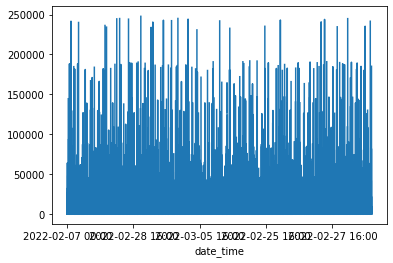

In [72]:
Movement_between_Tiles11['n_crisis'].plot()

### Population Density

In [ ]:
import glob2
import os
import pandas as pd

# the path to your csv file directory
mycsvdir = '/content/drive/MyDrive/EPP/Science Dissemination and Teaching Skills - Dem/Data/839283240656040_2022-02-07_2022-03-08_csv.zip (Unzipped Files)'

# get all the csv files in that directory (assuming they have the extension .csv)
csvfiles = glob2.glob(os.path.join(mycsvdir, '*.csv'))

# loop through the files and read them in with pandas
dataframes = []  # a list to hold all the individual pandas DataFrames
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    dataframes.append(df)

# concatenate them all together
Pop_density = pd.concat(dataframes, ignore_index=True)




In [ ]:
# print out to a new csv file
#Pop_density.to_csv('Pop_density.csv')

In [110]:
url2 = '/content/drive/MyDrive/EPP/Science Dissemination and Teaching Skills - Dem/Data/Pop_density.csv'
Pop_density = pd.read_csv(url2)

In [111]:
Pop_density

,Unnamed: 0,lat,lon,quadkey,country,date_time,n_baseline,n_crisis,n_difference,density_baseline,density_crisis,percent_change,clipped_z_score,ds
0,0,38.858959,-8.978577,3.311003e+14,PT,2022-02-10 00:00,NaN,NaN,NaN,NaN,NaN,0.593861,0.059504,2022-02-10
1,1,38.709089,-9.280701,3.311021e+14,PT,2022-02-10 00:00,25.397951,15.865420,-9.532531,0.000137,0.000124,-36.110873,-4.000000,2022-02-10
2,2,38.756225,-9.110413,3.311021e+14,PT,2022-02-10 00:00,117.506649,77.449921,-40.056728,0.000632,0.000603,-33.801250,-4.000000,2022-02-10
3,3,38.807611,-9.363098,3.311021e+14,PT,2022-02-10 00:00,16.668979,10.725527,-5.943452,0.000090,0.000084,-33.637776,-4.000000,2022-02-10
4,4,38.751941,-9.363098,3.311021e+14,PT,2022-02-10 00:00,NaN,NaN,NaN,NaN,NaN,-19.107101,-1.784638,2022-02-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535685,535685,38.653343,-8.956604,3.311021e+14,PT,2022-03-06 16:00,NaN,NaN,NaN,NaN,NaN,-46.582007,-1.369693,2022-03-06
535686,535686,38.876067,-9.396057,3.311003e+14,PT,2022-03-06 16:00,11.248250,10.488453,-0.759797,0.000049,0.000054,-6.203307,-0.508790,2022-03-06
535687,535687,38.679078,-8.956604,3.311021e+14,PT,2022-03-06 16:00,NaN,NaN,NaN,NaN,NaN,-20.558738,-2.384598,2022-03-06
535688,535688,38.661922,-9.071960,3.311021e+14,PT,2022-03-06 16:00,107.429050,93.087908,-14.341141,0.000465,0.000477,-13.226291,-2.248003,2022-03-06


In [112]:
#Maps
import geopandas as gpd

In [113]:
gdf = gpd.GeoDataFrame(Pop_density, geometry=gpd.points_from_xy(Pop_density.lon, Pop_density.lat))

In [114]:
from geopandas import GeoDataFrame
from shapely import wkt
gdf = GeoDataFrame(Pop_density['geometry'])
gdf = gdf.set_crs('epsg:4326')

In [115]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

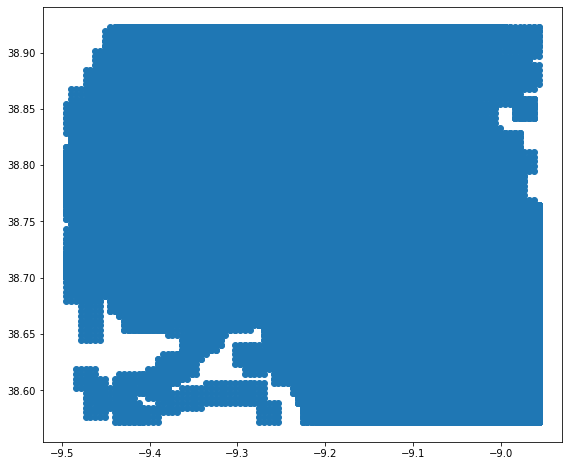

In [116]:
gdf.plot(figsize=(15, 8))

## Clipping (point within a polygon)

In [79]:
import folium
m = folium.Map(location=[38.73704372861349, -9.138758623542852], zoom_start=15)

marker = folium.Marker(
    location=[38.73704372861349, -9.138758623542852],
    popup="<stong>IST</stong>")
marker.add_to(m)

m

In [117]:
import geopy
import geopy.distance as distance
from shapely.geometry import Polygon

#Assume each site is 300m 
d = distance.distance(kilometers=100000/1000)

# Going clockwise, from lower-left to upper-left, upper-right...
p1 = geopy.Point((38.735419465303586, -9.140412026787729))
p2 = d.destination(point=p1, bearing=0)
p3 = d.destination(point=p2, bearing=90)
p4 = d.destination(point=p3, bearing=180)

points = [(p.longitude,p.latitude) for p in [p1,p2,p3,p4]]
polygon = Polygon(points)

In [118]:
points

[(-9.140412026787729, 38.735419465303586),
 (-9.140412026787729, 39.6361659109578),
 (-7.975591766924861, 39.63032565201555),
 (-7.975591766924861, 38.72957830088696)]

In [119]:
from shapely.geometry.base import CAP_STYLE
from shapely.geometry import Point
point = Point(38.73704372861349, -9.138758623542852)
buf = point.buffer(10)
print (buf.wkt)

POLYGON ((48.73704372861349 -9.138758623542852, 48.68889099533546 -10.118930026838457, 48.544896532645794 -11.089661843704135, 48.30644708593558 -12.041605396087476, 47.97583905372636 -12.96559294719375, 47.556256372097046 -13.852725991802828, 47.05173985163894 -14.694460953738874, 46.46714826224086 -15.482691465179307, 45.80811154047897 -16.209826435408328, 45.080976570249945 -16.86886315717022, 44.29274605880951 -17.453454746568305, 43.45101109687347 -17.9579712670264, 42.56387805226439 -18.37755394865572, 41.63989050115811 -18.708161980864944, 40.68794694877478 -18.946611427575156, 39.7172151319091 -19.09060589026482, 38.73704372861349 -19.138758623542852, 37.756872325317886 -19.090605890264822, 36.78614050845221 -18.946611427575156, 35.83419695606887 -18.708161980864944, 34.91020940496259 -18.37755394865572, 34.023076360353514 -17.9579712670264, 33.18134139841747 -17.453454746568305, 32.39311088697704 -16.868863157170225, 31.665975916748017 -16.209826435408328, 31.006939194986124 -

In [83]:
folium.Polygon(points).add_to(m)
m

In [120]:
bounding_box = polygon.envelope
df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
df = df.set_crs('epsg:4326')

In [121]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [122]:
import rtree
import geopandas as gpd

cjoin = gpd.sjoin(df,gdf, how="inner", predicate='intersects')

In [123]:
cjoin

,geometry,index_right
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",408091
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",472829
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",321840
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",387598
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",179441
...,...,...
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",3529
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",313661
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",481837
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",471121


In [124]:
Pop_density=Pop_density.rename(columns={'Unnamed: 0':'index_right'})

In [125]:
result3 = Pop_density.merge(cjoin, on='index_right')

In [126]:
result3

,index_right,lat,lon,quadkey,country,date_time,n_baseline,n_crisis,n_difference,density_baseline,density_crisis,percent_change,clipped_z_score,ds,geometry_x,geometry_y
0,0,38.858959,-8.978577,3.311003e+14,PT,2022-02-10 00:00,NaN,NaN,NaN,NaN,NaN,0.593861,0.059504,2022-02-10,POINT (-8.97858 38.85896),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
1,2,38.756225,-9.110413,3.311021e+14,PT,2022-02-10 00:00,117.506649,77.449921,-40.056728,0.000632,0.000603,-33.801250,-4.000000,2022-02-10,POINT (-9.11041 38.75623),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
2,31,38.901721,-9.011536,3.311003e+14,PT,2022-02-10 00:00,NaN,NaN,NaN,NaN,NaN,-1.670316,-0.176018,2022-02-10,POINT (-9.01154 38.90172),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
3,36,38.923092,-9.066467,3.311003e+14,NaN,2022-02-10 00:00,NaN,NaN,NaN,NaN,NaN,-13.411668,-0.496629,2022-02-10,POINT (-9.06647 38.92309),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
4,40,38.756225,-9.093933,3.311021e+14,PT,2022-02-10 00:00,48.328271,38.562006,-9.766265,0.000260,0.000300,-19.798515,-2.068425,2022-02-10,POINT (-9.09393 38.75623),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83161,535641,38.876067,-9.055481,3.311003e+14,NaN,2022-03-06 16:00,133.242421,111.643390,-21.599031,0.000577,0.000572,-16.089572,-2.399844,2022-03-06,POINT (-9.05548 38.87607),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
83162,535643,38.747657,-9.017029,3.311021e+14,PT,2022-03-06 16:00,NaN,NaN,NaN,NaN,NaN,5.809616,0.530893,2022-03-06,POINT (-9.01703 38.74766),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
83163,535649,38.923092,-9.066467,3.311003e+14,NaN,2022-03-06 16:00,NaN,NaN,NaN,NaN,NaN,-46.416720,-1.702525,2022-03-06,POINT (-9.06647 38.92309),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."
83164,535659,38.739088,-9.022522,3.311021e+14,PT,2022-03-06 16:00,NaN,NaN,NaN,NaN,NaN,-1.113613,-0.124383,2022-03-06,POINT (-9.02252 38.73909),"POLYGON ((-9.14041 38.72958, -7.97559 38.72958..."


In [127]:
# print out to a new csv file
#result3 = result3.to_csv('result3.csv')

In [ ]:
DATA_FILEPATH_temp3 = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/temperatura.csv' 
result3 = pd.read_csv(result3)
result3

In [91]:
gdf3 = gpd.GeoDataFrame(result3, geometry=gpd.points_from_xy(result3.lon, result3.lat))

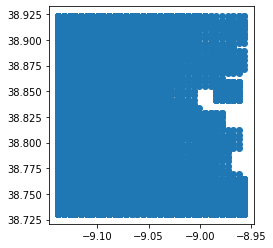

In [92]:
gdf3.plot()

In [93]:
locations = result3[['lat', 'lon']]
locationlist = locations.values.tolist()
len(locationlist)

83166

In [94]:
import folium
m = folium.Map(location=[38.73704372861349, -9.138758623542852], zoom_start=15)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(m)
m             

In [95]:
gdf2 = gpd.GeoDataFrame(Movement_between_Tiles, geometry=gpd.points_from_xy(Movement_between_Tiles.start_lon, Movement_between_Tiles.start_lat))
gdf2 = gdf2.set_crs('epsg:4326')

In [104]:
gdf2

,Unnamed: 0,GEOMETRY,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,country,level,...,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon,geometry
date_time,,,,,,,,,,,,,,,,,,,,,
2022-02-07 00:00,0,LINESTRING (-8.587408099576825 39.345130002418...,728344,Santarém,728344,Santarém,0.051256,12,PT,LEVEL3,...,22254.4,-5032.4,-22.612040,0.0,-4.000000,39.293550,-8.477500,39.293550,-8.477500,POINT (-8.47750 39.29355)
2022-02-07 00:00,1,"LINESTRING (-8.7064453125 39.25913117969706, -...",728344,Santarém,728341,Lisboa,54.095290,12,PT,LEVEL3,...,316.0,-17.0,-5.362776,0.0,-0.363143,39.293550,-8.477500,39.000731,-9.166223,POINT (-8.47750 39.29355)
2022-02-07 00:00,2,"LINESTRING (-8.2177734375 39.47011685244912, -...",728344,Santarém,728335,Castelo Branco,70.999280,12,PT,LEVEL3,...,NaN,NaN,-50.000000,0.0,-0.816497,39.293550,-8.477500,39.946475,-7.501654,POINT (-8.47750 39.29355)
2022-02-07 00:00,3,"LINESTRING (-1.0107421875 41.60721984533402, -...",881083,Zaragoza,881052,Guadalajara,214.665489,12,ES,LEVEL3,...,NaN,NaN,150.000000,0.0,1.788854,41.620031,-1.064567,40.813542,-2.623729,POINT (-1.06457 41.62003)
2022-02-07 00:00,4,"LINESTRING (-0.7763671875 41.65100891508348, 2...",881083,Zaragoza,881041,Barcelona,245.993659,12,ES,LEVEL3,...,25.6,-15.6,-58.646617,0.0,-2.244662,41.620031,-1.064567,41.730890,1.983811,POINT (-1.06457 41.62003)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17 16:00,46210,LINESTRING (-3.823242187499999 37.753335854854...,881056,Jaén,881062,Málaga,128.803494,12,ES,LEVEL3,...,NaN,NaN,-64.705882,0.0,-1.203786,38.016270,-3.441729,36.813829,-4.725932,POINT (-3.44173 38.01627)
2022-02-17 16:00,46211,LINESTRING (-3.8232421874999996 37.75333585485...,881056,Jaén,881074,Sevilla,197.459879,12,ES,LEVEL3,...,NaN,NaN,100.000000,0.0,0.894427,38.016270,-3.441729,37.435963,-5.683280,POINT (-3.44173 38.01627)
2022-02-17 16:00,46212,"LINESTRING (-4.04296875 37.9465891686263, -4.5...",881056,Jaén,881047,Córdoba,40.736098,12,ES,LEVEL3,...,72.8,-58.8,-79.674797,0.0,-2.327550,38.016270,-3.441729,37.992652,-4.809355,POINT (-3.44173 38.01627)


In [105]:
gdf3 = gpd.GeoDataFrame(Movement_between_Tiles, geometry=gpd.points_from_xy(Movement_between_Tiles.end_lon, Movement_between_Tiles.end_lat))
gdf3 = gdf3.set_crs('epsg:4326')

In [106]:
gdf3

,Unnamed: 0,GEOMETRY,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,country,level,...,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon,geometry
date_time,,,,,,,,,,,,,,,,,,,,,
2022-02-07 00:00,0,LINESTRING (-8.587408099576825 39.345130002418...,728344,Santarém,728344,Santarém,0.051256,12,PT,LEVEL3,...,22254.4,-5032.4,-22.612040,0.0,-4.000000,39.293550,-8.477500,39.293550,-8.477500,POINT (-8.47750 39.29355)
2022-02-07 00:00,1,"LINESTRING (-8.7064453125 39.25913117969706, -...",728344,Santarém,728341,Lisboa,54.095290,12,PT,LEVEL3,...,316.0,-17.0,-5.362776,0.0,-0.363143,39.293550,-8.477500,39.000731,-9.166223,POINT (-9.16622 39.00073)
2022-02-07 00:00,2,"LINESTRING (-8.2177734375 39.47011685244912, -...",728344,Santarém,728335,Castelo Branco,70.999280,12,PT,LEVEL3,...,NaN,NaN,-50.000000,0.0,-0.816497,39.293550,-8.477500,39.946475,-7.501654,POINT (-7.50165 39.94647)
2022-02-07 00:00,3,"LINESTRING (-1.0107421875 41.60721984533402, -...",881083,Zaragoza,881052,Guadalajara,214.665489,12,ES,LEVEL3,...,NaN,NaN,150.000000,0.0,1.788854,41.620031,-1.064567,40.813542,-2.623729,POINT (-2.62373 40.81354)
2022-02-07 00:00,4,"LINESTRING (-0.7763671875 41.65100891508348, 2...",881083,Zaragoza,881041,Barcelona,245.993659,12,ES,LEVEL3,...,25.6,-15.6,-58.646617,0.0,-2.244662,41.620031,-1.064567,41.730890,1.983811,POINT (1.98381 41.73089)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17 16:00,46210,LINESTRING (-3.823242187499999 37.753335854854...,881056,Jaén,881062,Málaga,128.803494,12,ES,LEVEL3,...,NaN,NaN,-64.705882,0.0,-1.203786,38.016270,-3.441729,36.813829,-4.725932,POINT (-4.72593 36.81383)
2022-02-17 16:00,46211,LINESTRING (-3.8232421874999996 37.75333585485...,881056,Jaén,881074,Sevilla,197.459879,12,ES,LEVEL3,...,NaN,NaN,100.000000,0.0,0.894427,38.016270,-3.441729,37.435963,-5.683280,POINT (-5.68328 37.43596)
2022-02-17 16:00,46212,"LINESTRING (-4.04296875 37.9465891686263, -4.5...",881056,Jaén,881047,Córdoba,40.736098,12,ES,LEVEL3,...,72.8,-58.8,-79.674797,0.0,-2.327550,38.016270,-3.441729,37.992652,-4.809355,POINT (-4.80936 37.99265)


In [99]:
import rtree
import geopandas as gpd

cjoin2 = gpd.sjoin(df,gdf2, how="inner")

In [107]:
cjoin2

,geometry,index_right,Unnamed: 0,GEOMETRY,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,...,n_crisis,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-10 16:00,4435,"LINESTRING (-8.1494140625 39.496489204288224, ...",728344,Santarém,728342,Portalegre,19.399034,12,...,20.0,24.2,-4.2,-16.666667,0.0,-0.998304,39.29355,-8.4775,39.190007,-7.620561
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-26 00:00,42653,"LINESTRING (-8.3056640625 39.67336211059663, -...",728344,Santarém,728335,Castelo Branco,7.522248,12,...,NaN,NaN,NaN,0.000000,0.0,0.000000,39.29355,-8.4775,39.946475,-7.501654
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-26 00:00,42649,"LINESTRING (-8.9208984375 38.788337125984256, ...",728344,Santarém,728345,Setúbal,7.926355,12,...,19.0,52.0,-33.0,-62.264151,0.0,-4.000000,39.29355,-8.4775,38.336140,-8.669152
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-23 08:00,14136,LINESTRING (-8.58544725515248 39.3510795694076...,728344,Santarém,728344,Santarém,0.255119,12,...,14921.0,19836.2,-4915.2,-24.777690,0.0,-4.000000,39.29355,-8.4775,39.293550,-8.477500
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-03-05 08:00,23341,LINESTRING (-8.884708180147058 38.838653288894...,728344,Santarém,728345,Setúbal,15.036186,12,...,32.0,72.4,-40.4,-55.040872,0.0,-3.473221,39.29355,-8.4775,38.336140,-8.669152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-03-01 08:00,27561,LINESTRING (-8.754475911458332 39.119400405045...,728344,Santarém,728341,Lisboa,30.183750,12,...,217.0,832.0,-615.0,-73.829532,0.0,-2.301088,39.29355,-8.4775,39.000731,-9.166223
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-09 00:00,34982,LINESTRING (-8.393554687500002 39.605679900855...,728344,Santarém,728336,Coimbra,67.467907,12,...,NaN,NaN,NaN,212.500000,0.0,2.534210,39.29355,-8.4775,40.204387,-8.335865
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-03-07 16:00,17051,"LINESTRING (-8.3056640625 38.99356381633291, -...",728344,Santarém,728337,Évora,16.992792,12,...,NaN,NaN,NaN,-32.432432,0.0,-0.585540,39.29355,-8.4775,38.603945,-7.841927
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-13 16:00,9455,LINESTRING (-8.680154551630435 39.236316601725...,728344,Santarém,728345,Setúbal,69.690865,12,...,139.0,238.4,-99.4,-41.520468,0.0,-2.239909,39.29355,-8.4775,38.336140,-8.669152


In [108]:
import rtree
import geopandas as gpd

cjoin3 = gpd.sjoin(df,gdf3, how="inner")

In [109]:
cjoin3

,geometry,index_right,Unnamed: 0,GEOMETRY,start_polygon_id,start_polygon_name,end_polygon_id,end_polygon_name,length_km,tile_size,...,n_crisis,n_baseline,n_difference,percent_change,is_statistically_significant,z_score,start_lat,start_lon,end_lat,end_lon
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-25 08:00,32660,"LINESTRING (-8.3935546875 40.212432409272985, ...",728336,Coimbra,728344,Santarém,71.117393,12,...,NaN,NaN,NaN,-64.705882,0.0,-1.181590,40.204387,-8.335865,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-20 16:00,38271,LINESTRING (-8.425514914772727 40.212432409272...,728336,Coimbra,728344,Santarém,82.239156,12,...,11.0,12.2,-1.2,-9.090909,0.0,-0.251865,40.204387,-8.335865,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-28 16:00,10385,LINESTRING (-9.02733479071101 38.7141209060254...,728345,Setúbal,728344,Santarém,43.836846,12,...,107.0,157.8,-50.8,-31.989924,0.0,-3.727844,38.336140,-8.669152,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-03-05 16:00,19958,LINESTRING (-8.569335937499998 40.946705322873...,728331,Aveiro,728344,Santarém,149.301729,12,...,NaN,NaN,NaN,-66.666667,0.0,-1.206045,40.723754,-8.468493,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-26 08:00,23775,LINESTRING (-8.746419270833334 39.638173945345...,728340,Leiria,728344,Santarém,8.599111,12,...,134.0,254.0,-120.0,-47.058824,0.0,-4.000000,39.717327,-8.775099,39.29355,-8.4775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-12 00:00,3989,LINESTRING (-8.924153645833334 38.709632605911...,728345,Setúbal,728344,Santarém,14.847600,12,...,29.0,69.4,-40.4,-57.386364,0.0,-3.060079,38.336140,-8.669152,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-12 08:00,36350,LINESTRING (-8.607003348214286 40.537617824180...,728331,Aveiro,728344,Santarém,103.715008,12,...,NaN,NaN,NaN,80.000000,0.0,3.265986,40.723754,-8.468493,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-02-14 00:00,26537,LINESTRING (-9.013455821349558 38.917172864030...,728341,Lisboa,728344,Santarém,29.965736,12,...,111.0,175.0,-64.0,-36.363636,0.0,-2.093584,39.000731,-9.166223,39.29355,-8.4775
0,"POLYGON ((-9.14041 38.72958, -7.97559 38.72958...",2022-03-04 08:00,19317,LINESTRING (-8.773961601110038 39.606346269642...,728340,Leiria,728344,Santarém,9.457172,12,...,260.0,420.5,-160.5,-38.078292,0.0,-4.000000,39.717327,-8.775099,39.29355,-8.4775


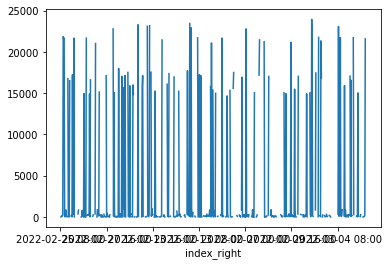

In [102]:
cjoin3.set_index('index_right', inplace=True, drop=True)
cjoin3 = cjoin3[cjoin3['length_km'] > 0]  
cjoin3['n_crisis'].plot()